
# Unified (Mixed Numerical + Categorical → Classification): MLP **or** RNN → SHAP → STAT-XAI

**Pipeline (same for both models):** load → split → preprocess → train → predict → **SHAP** → **STAT‑XAI** → save plots/CSVs.  
Set `MODEL = "MLP"` or `"RNN"` in the **Configuration** cell.


In [ ]:

# Optional: install deps if needed in your kernel
# !pip install -q pandas numpy scikit-learn matplotlib shap scipy psutil statsmodels torch --index-url https://download.pytorch.org/whl/cpu


In [5]:

from __future__ import annotations

import os, itertools, logging
from typing import Sequence, Tuple, Dict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, pointbiserialr, chi2
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import shap
import psutil

# Torch (RNN path)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

pd.set_option("display.max_columns", 300)
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")


## Configuration

In [3]:

# ================= User Config =================
MODEL = "MLP"   # <-- "MLP" or "RNN"

DATA_PATH = "/Users/arsh/STAT-XAI/Datasets/Synthetic/Loan Approval Categorical Numerical Synthetic Dataset Continous Outcome.csv"  # <- update if needed
TARGET = "Approval_Probability"

NUMERIC_FEATURES = ['Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term']
CATEGORICAL_FEATURES = ['Loan_Purpose','Employment_Status','Loan_Categories','Region','Marital_Status']

TEST_SIZE = 0.30
RANDOM_STATE = 42
THRESHOLD = 0.5
ALPHA = 0.05

# SHAP
SHAP_BATCH_SIZE = 2000
SHAP_PLOT_SAMPLE = 1200

# RNN
EPOCHS = 60
BATCH_TRAIN = 64
BATCH_TEST = 256
EMB_DIM = 16
RNN_HIDDEN = 32
RNN_LAYERS = 1

# Outputs
OUTPUT_DIR = "outputs_mixed"
PLOTS_DIR  = os.path.join(OUTPUT_DIR, "plots")
TABLES_DIR = os.path.join(OUTPUT_DIR, "tables")
SHAP_DIR   = os.path.join(OUTPUT_DIR, "shap")
for d in [OUTPUT_DIR, PLOTS_DIR, TABLES_DIR, SHAP_DIR]:
    os.makedirs(d, exist_ok=True)

print("MODEL:", MODEL)
print("Saving under:", OUTPUT_DIR)


NameError: name 'os' is not defined

## Helpers

In [29]:

def cramers_v(tbl: pd.DataFrame) -> float:
    chi2_stat = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))


def statxai_mixed(merged_df: pd.DataFrame,
                  numeric_features: Sequence[str],
                  categorical_features: Sequence[str],
                  model_suffix: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Ensure cat dtype
    for col in categorical_features:
        if col in merged_df:
            merged_df[col] = merged_df[col].astype('category')

    # 1) MAIN
    records = []
    main_effects = {}

    for feat in numeric_features:
        r, p = pointbiserialr(merged_df[feat], merged_df['Predicted_Label'])
        effect = abs(r) if p < ALPHA else 0.0
        main_effects[feat] = float(effect)
        records.append({'Feature': feat, 'Type': 'Numeric',
                        'p_value': round(float(p), 6),
                        'effect_size': round(float(effect), 6)})

    for feat in categorical_features:
        conf = pd.crosstab(merged_df[feat], merged_df['Predicted_Label'])
        chi2_stat, p, _, _ = chi2_contingency(conf, correction=False)
        effect = cramers_v(conf) if p < ALPHA else 0.0
        main_effects[feat] = float(effect)
        records.append({'Feature': feat, 'Type': 'Categorical',
                        'p_value': round(float(p), 6),
                        'effect_size': round(float(effect), 6)})

    main_df = (pd.DataFrame(records)
               .sort_values('effect_size', ascending=False)
               .reset_index(drop=True))
    main_df.to_csv(os.path.join(TABLES_DIR, f"main_effects_{model_suffix}.csv"), index=False)

    # 2) PAIRWISE via LRT ΔMcFadden’s R²
    inter_records = []
    features = list(numeric_features) + list(categorical_features)
    null_model = smf.logit("Predicted_Label ~ 1", merged_df).fit(disp=False)
    llnull = null_model.llf

    pair_sums = {feat: 0.0 for feat in features}

    for f1, f2 in itertools.combinations(features, 2):
        try:
            t1 = f"C({f1})" if f1 in categorical_features else f1
            t2 = f"C({f2})" if f2 in categorical_features else f2
            full = smf.logit(f"Predicted_Label ~ {t1} * {t2}", merged_df).fit(disp=False)
            red  = smf.logit(f"Predicted_Label ~ {t1} + {t2}", merged_df).fit(disp=False)
            LR_stat = 2 * (full.llf - red.llf)
            df_diff = int(full.df_model - red.df_model)
            p_val   = chi2.sf(LR_stat, df_diff)
            R2_full = 1 - full.llf / llnull
            R2_red  = 1 - red.llf  / llnull
            delta_R2 = float(R2_full - R2_red)
    
            significant = p_val < ALPHA
                
            inter_records.append({'Feature Pair': f"{f1} × {f2}",
                                      'p_value': round(float(p_val), 6),
                                      'effect_size_ΔMcF2': round(delta_R2, 6),
                                      'Significant?': 'Yes' if p_val < ALPHA else 'No'})
            if p_val < ALPHA:
                pair_sums[f1] += delta_R2
                pair_sums[f2] += delta_R2
        except Exception as e:
            inter_records.append({'Feature Pair': f"{f1} × {f2}",
                                  'p_value': np.nan,
                                  'effect_size_ΔMcF2': np.nan,
                                  'Significant?': 'NA'})

    pairwise_df = (pd.DataFrame(inter_records)
                   .sort_values('effect_size_ΔMcF2', ascending=False)
                   .reset_index(drop=True))
    pairwise_df.to_csv(os.path.join(TABLES_DIR, f"pairwise_interactions_{model_suffix}.csv"), index=False)

    # 3) FINAL
    final_records = []
    for feat in features:
        main_eff = main_effects.get(feat, 0.0)
        inter_sum = pair_sums.get(feat, 0.0)
        final_records.append({'Feature': feat,
                              'Main Effect': round(float(main_eff), 6),
                              'Sum Interaction (ΔMcF2)': round(float(inter_sum), 6),
                              'Final Score': round(float(main_eff + inter_sum), 6)})
    final_df = (pd.DataFrame(final_records)
                .sort_values('Final Score', ascending=False)
                .reset_index(drop=True))
    final_df.to_csv(os.path.join(TABLES_DIR, f"final_scores_{model_suffix}.csv"), index=False)

    # Plots
    if not main_df.empty:
        plt.figure()
        plt.bar(main_df['Feature'], main_df['effect_size'])
        plt.xticks(rotation=60, ha='right'); plt.ylabel('Effect Size')
        plt.title(f'{model_suffix}: Main Effects (Descending)')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"main_effects_bar_{model_suffix}.png"), dpi=300)
        plt.show()

    if not pairwise_df.empty:
        dfi = pairwise_df.dropna(subset=['effect_size_ΔMcF2']).head(15)
        if not dfi.empty:
            plt.figure()
            plt.bar(dfi['Feature Pair'], dfi['effect_size_ΔMcF2'])
            plt.xticks(rotation=60, ha='right'); plt.ylabel('ΔMcFadden R²')
            plt.title(f'{model_suffix}: Top Pairwise Effects')
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_DIR, f"pairwise_effects_bar_{model_suffix}.png"), dpi=300)
            plt.show()

    if not final_df.empty:
        plt.figure()
        plt.bar(final_df['Feature'], final_df['Final Score'])
        plt.xticks(rotation=60, ha='right'); plt.ylabel('Final Score (main + interactions)')
        plt.title(f'{model_suffix}: Final Scores (Descending)')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"final_effects_bar_{model_suffix}.png"), dpi=300)
        plt.show()

    return main_df, pairwise_df, final_df


## Load & Split

In [7]:

df = pd.read_csv(DATA_PATH)
if df.columns[0].lower() in {"unnamed: 0", "index", "id"}:
    df = df.drop(df.columns[0], axis=1)

assert TARGET in df.columns, f"Target '{TARGET}' not found"
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
X_test_original = X_test.copy()

display(df.head())
print("Train/Test:", X_train.shape, X_test.shape)


,Annual_Income,Credit_Score,Employment_Length,Age,Loan_Term,Loan_Purpose,Employment_Status,Loan_Categories,Region,Marital_Status,Approval_Probability
0,74944.814262,505.502450,14.599966,30,28,Personal,Self-employed,Medium,West,Married,1
1,144085.716769,483.101653,3.690240,44,14,Home,Employed,Small,South,Divorced,1
2,117839.273017,396.884652,6.932794,55,27,Home,Unemployed,Large,South,Single,0
3,101839.018104,633.996669,13.265613,50,1,Personal,Employed,Small,North,Divorced,1
4,48722.236853,562.143288,9.641787,23,28,Car,Self-employed,Small,South,Single,1


Train/Test: (8000, 10) (2000, 10)


## Train & Predict (MLP or RNN)

In [9]:

if MODEL.upper() == "MLP":
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERIC_FEATURES),
            ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
        ]
    ).fit(X_train)

    X_train_tf = preprocessor.transform(X_train)
    X_test_tf  = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    mlp = MLPClassifier(hidden_layer_sizes=(128,64,32,16), max_iter=1, warm_start=True, random_state=RANDOM_STATE)
    classes = np.unique(y_train)
    for ep in range(200):
        if ep == 0:
            mlp.partial_fit(X_train_tf, y_train, classes=classes)
        else:
            mlp.partial_fit(X_train_tf, y_train)
        if (ep+1) % 20 == 0 or ep == 0:
            print(f"Epoch {ep+1:03d} | Loss: {mlp.loss_:.4f}")

    probs = mlp.predict_proba(X_test_tf)[:,1]
    y_pred = (probs > THRESHOLD).astype(int)

    print(f"MLP Test Accuracy @ {THRESHOLD:.2f}: {accuracy_score(y_test, y_pred):.4f}")
    print(f"MLP Test ROC AUC              : {roc_auc_score(y_test, probs):.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    # Drop last col (prob) per your request
    # merged_df['Predicted_Prob'] = probs
    merged_df.to_csv(os.path.join(TABLES_DIR, "test_predictions_merged_MLP_mixed.csv"), index=False)

    MODEL_SUFFIX = "MLP_mixed"


Epoch 001 | Loss: 0.5268
Epoch 020 | Loss: 0.1511
Epoch 040 | Loss: 0.0894
Epoch 060 | Loss: 0.0539
Epoch 080 | Loss: 0.0262
Epoch 100 | Loss: 0.0565
Epoch 120 | Loss: 0.0056
Epoch 140 | Loss: 0.0025
Epoch 160 | Loss: 0.0010
Epoch 180 | Loss: 0.0217
Epoch 200 | Loss: 0.0011
MLP Test Accuracy @ 0.50: 0.8905
MLP Test ROC AUC              : 0.9663


In [ ]:

if MODEL.upper() == "RNN":
    # Build categorical ID maps
    mappings: Dict[str, Dict[str,int]] = {}
    for col in CATEGORICAL_FEATURES:
        cats = pd.Series(pd.concat([X_train[col], X_test[col]], ignore_index=True), dtype="category").cat.categories.tolist()
        mp = {c:i for i,c in enumerate(cats)}
        mp["<UNK>"] = len(mp)
        mappings[col] = mp

    train_df = X_train.copy()
    test_df  = X_test.copy()
    for col, mp in mappings.items():
        train_df[col] = train_df[col].map(mp).fillna(mp["<UNK>"]).astype(int)
        test_df[col]  = test_df[col].map(mp).fillna(mp["<UNK>"]).astype(int)

    scaler = StandardScaler().fit(train_df[NUMERIC_FEATURES])
    X_train_num = scaler.transform(train_df[NUMERIC_FEATURES])
    X_test_num  = scaler.transform(test_df[NUMERIC_FEATURES])
    X_train_cat = train_df[CATEGORICAL_FEATURES].values.astype(int)
    X_test_cat  = test_df[CATEGORICAL_FEATURES].values.astype(int)

    class MixedDataset(Dataset):
        def __init__(self, Xn, Xc, y):
            self.Xn = torch.from_numpy(Xn).float()
            self.Xc = torch.from_numpy(Xc).long()
            self.y  = torch.from_numpy(np.asarray(y)).float().unsqueeze(1)
        def __len__(self): return len(self.y)
        def __getitem__(self, i): return self.Xn[i], self.Xc[i], self.y[i]

    train_dl = DataLoader(MixedDataset(X_train_num, X_train_cat, y_train.values), batch_size=BATCH_TRAIN, shuffle=True)
    test_dl  = DataLoader(MixedDataset(X_test_num,  X_test_cat,  y_test.values),  batch_size=BATCH_TEST)

    class MixedRNN(nn.Module):
        def __init__(self, num_feats, cat_dims, emb_dim=EMB_DIM, hidden=RNN_HIDDEN, layers=RNN_LAYERS):
            super().__init__()
            self.num_proj = nn.ModuleList([nn.Linear(1, emb_dim) for _ in range(num_feats)])
            self.cat_emb  = nn.ModuleList([nn.Embedding(dim, emb_dim) for dim in cat_dims])
            self.rnn      = nn.RNN(emb_dim, hidden, layers, batch_first=True)
            self.head     = nn.Linear(hidden, 1)
        def forward(self, Xn, Xc):
            num_emb = [proj(Xn[:,i].unsqueeze(-1)) for i, proj in enumerate(self.num_proj)]
            cat_emb = [emb(Xc[:,i]) for i, emb in enumerate(self.cat_emb)]
            seq = torch.stack(num_emb + cat_emb, dim=1)
            _, h = self.rnn(seq)
            return self.head(h[-1])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MixedRNN(len(NUMERIC_FEATURES), [len(mappings[c]) for c in CATEGORICAL_FEATURES]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for ep in range(1, EPOCHS+1):
        model.train(); tot=0.0
        for Xn, Xc, yb in train_dl:
            Xn, Xc, yb = Xn.to(device), Xc.to(device), yb.to(device)
            loss = loss_fn(model(Xn, Xc), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item()*Xn.size(0)
        if ep % 10 == 0 or ep == 1:
            print(f"Epoch {ep:02d} | Train Loss = {tot/len(train_dl.dataset):.4f}")

    # Evaluate
    model.eval(); probs_list, preds_list, trues_list = [], [], []
    with torch.no_grad():
        for Xn, Xc, yb in test_dl:
            Xn, Xc = Xn.to(device), Xc.to(device)
            p = torch.sigmoid(model(Xn, Xc)).cpu().numpy().flatten()
            probs_list.extend(p); preds_list.extend((p>THRESHOLD).astype(int)); trues_list.extend(yb.numpy().flatten().astype(int))

    probs = np.array(probs_list); y_pred = np.array(preds_list)
    print(f"RNN Test Accuracy @ {THRESHOLD:.2f}: {accuracy_score(trues_list, preds_list):.4f}")
    print(f"RNN Test ROC AUC              : {roc_auc_score(trues_list, probs):.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    # Drop prob column (not added) to mirror your request
    merged_df.to_csv(os.path.join(TABLES_DIR, 'test_predictions_merged_RNN_mixed.csv'), index=False)

    MODEL_SUFFIX = "RNN_mixed"

    # Save arrays for SHAP section
    X_train_num_arr, X_test_num_arr = X_train_num, X_test_num
    X_train_cat_arr, X_test_cat_arr = X_train_cat, X_test_cat


## SHAP

In [ ]:

if MODEL.upper() == "MLP":
    logging.info("SHAP (MLP): transformed features → aggregate back to original features")
    explainer = shap.Explainer(lambda x: mlp.predict_proba(x)[:,1], X_train_tf)
    all_vals = []
    n = X_test_tf.shape[0]
    for start in range(0, n, SHAP_BATCH_SIZE):
        end = min(start + SHAP_BATCH_SIZE, n)
        sv = explainer(X_test_tf[start:end])
        all_vals.append(sv.values)
    shap_values = np.vstack(all_vals)
    np.save(os.path.join(SHAP_DIR, "shap_values_MLP_mixed.npy"), shap_values)

    fn = list(feature_names)
    parent_map = {}
    for name in fn:
        typ, rest = name.split("__", 1)
        parent = rest if typ == "num" else rest.rsplit("_", 1)[0]
        parent_map[name] = parent

    mean_abs = pd.Series(np.abs(shap_values).mean(axis=0), index=fn)
    mean_orig = mean_abs.groupby(parent_map).sum().reindex(NUMERIC_FEATURES + CATEGORICAL_FEATURES)
    mean_orig_sorted = mean_orig.sort_values(ascending=False)

    # Plots
    k = min(SHAP_PLOT_SAMPLE, shap_values.shape[0])
    idx = np.random.default_rng(7).choice(shap_values.shape[0], size=k, replace=False)
    try:
        shap.summary_plot(shap_values[idx], X_test_tf[idx], feature_names=fn, show=False)
        plt.title("MLP SHAP summary (transformed)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, "shap_summary_beeswarm_MLP_mixed.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Beeswarm failed: {e}")
    try:
        shap.summary_plot(shap_values[idx], X_test_tf[idx], feature_names=fn, plot_type="bar", show=False)
        plt.title("MLP Mean |SHAP| per transformed feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, "shap_summary_bar_MLP_mixed.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Bar failed: {e}")

    plt.figure(figsize=(6,4))
    mean_orig_sorted.plot.barh()
    plt.xlabel("mean(|SHAP|)"); plt.title("MLP — Mean |SHAP| by original feature")
    plt.gca().invert_yaxis(); plt.tight_layout()
    plt.savefig(os.path.join(SHAP_DIR, "shap_bar_original_MLP_mixed.png"), dpi=300); plt.show()

elif MODEL.upper() == "RNN":
    logging.info("SHAP (RNN): KernelExplainer on concatenated [num|cat] features")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def rnn_predict_np(X_concat: np.ndarray) -> np.ndarray:
        n_num = len(NUMERIC_FEATURES)
        Xn = torch.from_numpy(X_concat[:, :n_num]).float().to(device)
        Xc = torch.from_numpy(X_concat[:, n_num:].astype(np.int64)).long().to(device)
        with torch.no_grad():
            p = torch.sigmoid(model(Xn, Xc)).cpu().numpy().flatten()
        return p

    X_train_concat = np.concatenate([X_train_num_arr, X_train_cat_arr], axis=1)
    X_test_concat  = np.concatenate([X_test_num_arr,  X_test_cat_arr],  axis=1)

    bg = min(200, X_train_concat.shape[0])
    ex = min(SHAP_PLOT_SAMPLE, X_test_concat.shape[0])
    bg_idx = np.random.default_rng(7).choice(X_train_concat.shape[0], size=bg, replace=False)
    ex_idx = np.random.default_rng(13).choice(X_test_concat.shape[0], size=ex, replace=False)

    explainer = shap.KernelExplainer(rnn_predict_np, X_train_concat[bg_idx])
    sv = explainer.shap_values(X_test_concat[ex_idx], nsamples=200)
    shap_values = sv[0] if isinstance(sv, list) else sv
    np.save(os.path.join(SHAP_DIR, "shap_values_RNN_mixed.npy"), shap_values)

    feat_names = NUMERIC_FEATURES + CATEGORICAL_FEATURES
    try:
        shap.summary_plot(shap_values, X_test_concat[ex_idx], feature_names=feat_names, show=False)
        plt.title("RNN SHAP summary (KernelExplainer)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, "shap_summary_beeswarm_RNN_mixed.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN beeswarm failed: {e}")
    try:
        shap.summary_plot(shap_values, X_test_concat[ex_idx], feature_names=feat_names, plot_type="bar", show=False)
        plt.title("RNN Mean |SHAP| per feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, "shap_summary_bar_RNN_mixed.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN bar failed: {e}")


## STAT‑XAI (Mixed): Tables & Plots

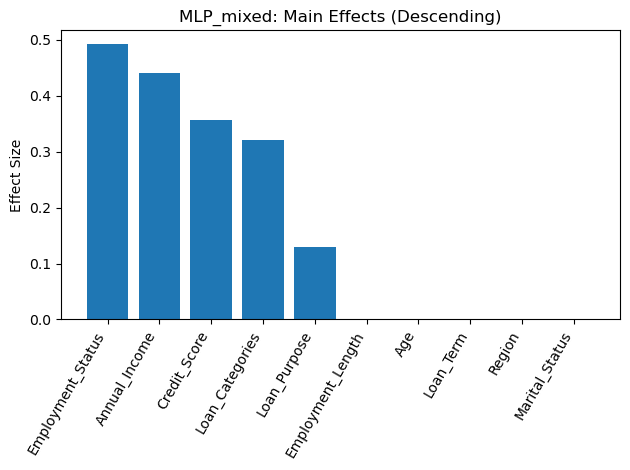

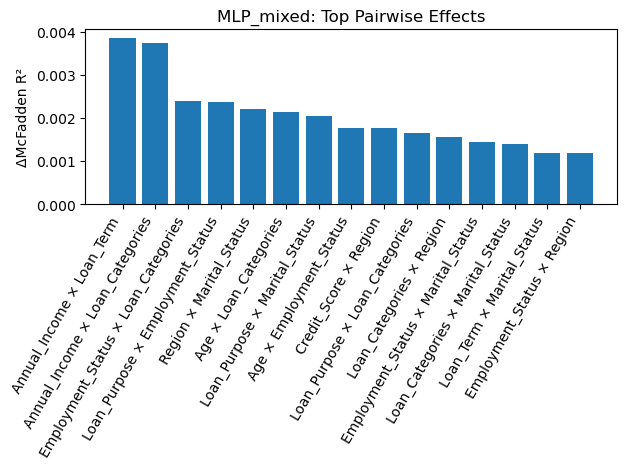

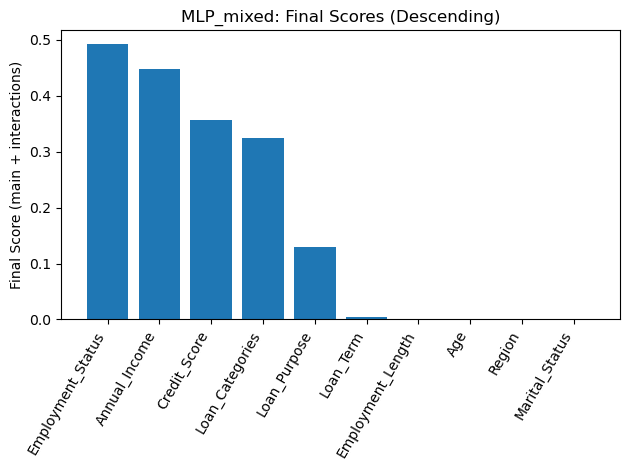

,Feature,Type,p_value,effect_size
0,Employment_Status,Categorical,0.000000,0.491968
1,Annual_Income,Numeric,0.000000,0.439601
2,Credit_Score,Numeric,0.000000,0.356898
3,Loan_Categories,Categorical,0.000000,0.321242
4,Loan_Purpose,Categorical,0.000000,0.130043
5,Employment_Length,Numeric,0.090405,0.000000
6,Age,Numeric,0.523726,0.000000
7,Loan_Term,Numeric,0.830478,0.000000
8,Region,Categorical,0.161787,0.000000
9,Marital_Status,Categorical,0.497124,0.000000


,Feature Pair,p_value,effect_size_ΔMcF2,Significant?
0,Annual_Income × Loan_Term,0.001067,0.003863,Yes
1,Annual_Income × Loan_Categories,0.005565,0.003745,Yes
2,Employment_Status × Loan_Categories,0.158125,0.002384,No
3,Loan_Purpose × Employment_Status,0.159668,0.002374,No
4,Region × Marital_Status,0.407243,0.002216,No
5,Age × Loan_Categories,0.051027,0.002147,No
6,Loan_Purpose × Marital_Status,0.227361,0.002036,No
7,Age × Employment_Status,0.086044,0.001770,No
8,Credit_Score × Region,0.181844,0.001755,No
9,Loan_Purpose × Loan_Categories,0.335464,0.001645,No


,Feature,Main Effect,Sum Interaction (ΔMcF2),Final Score
0,Employment_Status,0.491968,0.000000,0.491968
1,Annual_Income,0.439601,0.007608,0.447209
2,Credit_Score,0.356898,0.000000,0.356898
3,Loan_Categories,0.321242,0.003745,0.324987
4,Loan_Purpose,0.130043,0.000000,0.130043
5,Loan_Term,0.000000,0.003863,0.003863
6,Employment_Length,0.000000,0.000000,0.000000
7,Age,0.000000,0.000000,0.000000
8,Region,0.000000,0.000000,0.000000
9,Marital_Status,0.000000,0.000000,0.000000


In [31]:

main_df, pairwise_df, final_df = statxai_mixed(
    merged_df.copy(), NUMERIC_FEATURES, CATEGORICAL_FEATURES,
    MODEL_SUFFIX if 'MODEL_SUFFIX' in globals() else 'MLP_mixed'
)
display(main_df); display(pairwise_df); display(final_df)
